In [4]:
import os
import json
import pandas as pd
import numpy as np
from pymongo import MongoClient
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [6]:
# MongoDB connection
# Set your connection string here or use environment variable
connection_string = os.getenv("MONGODB_CONNECTION_STRING", "your_connection_string_here")

if connection_string == "your_connection_string_here":
    print("⚠️ Please set MONGODB_CONNECTION_STRING environment variable or update the connection_string above")
else:
    client = MongoClient(connection_string, serverSelectionTimeoutMS=5000)
    db = client["prj-nemo"]
    collection = db["human-study-pilot"]
    
    # Test connection
    try:
        client.admin.command('ping')
        print("Successfully connected to MongoDB")
        print(f"Collection: {collection.name}")
        print(f"Total documents: {collection.count_documents({})}")
    except Exception as e:
        print(f"❌ Failed to connect: {e}")


Successfully connected to MongoDB
Collection: human-study-pilot
Total documents: 100


In [13]:
# Date range filter
# Set your date range here (leave None to load all data)
# Format: "YYYY-MM-DD" or "YYYY-MM-DD HH:MM:SS"
start_date = "2025-12-05"  # e.g., "2024-01-01" or "2024-01-01 00:00:00"
end_date = "2025-12-05"    # e.g., "2024-12-31" or "2024-12-31 23:59:59"

# Convert string dates to datetime if provided
if start_date:
    if isinstance(start_date, str):
        try:
            start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            start_date = datetime.strptime(start_date, "%Y-%m-%d")
    start_date = start_date.replace(tzinfo=None)  # Remove timezone for MongoDB query

if end_date:
    if isinstance(end_date, str):
        try:
            end_date = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")
        except ValueError:
            end_date = datetime.strptime(end_date, "%Y-%m-%d")
    # Set to end of day if only date provided
    if end_date.hour == 0 and end_date.minute == 0:
        end_date = end_date.replace(hour=23, minute=59, second=59)
    end_date = end_date.replace(tzinfo=None)

# Build query filter
query_filter = {}
if start_date or end_date:
    timestamp_filter = {}
    if start_date:
        timestamp_filter["$gte"] = start_date
    if end_date:
        timestamp_filter["$lte"] = end_date
    if timestamp_filter:
        query_filter["timestamp"] = timestamp_filter

print(f"🔍 Query filter: {query_filter if query_filter else 'No filter (loading all data)'}")
if start_date:
    print(f"   Start date: {start_date}")
if end_date:
    print(f"   End date: {end_date}")


🔍 Query filter: {'timestamp': {'$gte': datetime.datetime(2025, 12, 5, 0, 0), '$lte': datetime.datetime(2025, 12, 5, 23, 59, 59)}}
   Start date: 2025-12-05 00:00:00
   End date: 2025-12-05 23:59:59


In [16]:
# Load all data from MongoDB
if connection_string != "your_connection_string_here":
    cursor = collection.find(query_filter)  # query_filter 사용
    data = list(cursor)
    
    print(f"📥 Loaded {len(data)} responses")
    
    if len(data) > 0:
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Convert timestamp to datetime if it's not already
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Display basic info
        print(f"\n📋 Columns: {list(df.columns)}")
        print(f"\n👥 Unique participants: {df['participant_id'].nunique()}")
        print(f"📸 Unique samples: {df['sample_key'].nunique()}")
        
        if 'timestamp' in df.columns:
            print(f"📅 Date range in data: {df['timestamp'].min()} to {df['timestamp'].max()}")
        
        # Display first few rows
        display(df.head())
    else:
        print("⚠️ No data found for the specified date range")
        df = pd.DataFrame()  # Empty DataFrame
        data = []  # Empty list
else:
    print("⚠️ Please configure MongoDB connection first")
    df = pd.DataFrame()  # Empty DataFrame
    data = [] 


📥 Loaded 91 responses

📋 Columns: ['_id', 'sample_key', 'participant_id', 'cei_scores', 'dataset', 'explanation_order', 'original_explanations', 'predicted_class', 'ranking_feedback', 'rankings', 'target_model', 'timestamp', 'true_class']

👥 Unique participants: 24
📸 Unique samples: 4
📅 Date range in data: 2025-12-05 05:36:30.282000 to 2025-12-05 07:15:42.515000


,_id,sample_key,participant_id,cei_scores,dataset,explanation_order,original_explanations,predicted_class,ranking_feedback,rankings,target_model,timestamp,true_class
0,69326f5e72717a9c93cfb5b9,7291,taesoo,"{'retrieval': 38.940297812223434, 'pixel': 31....",imagenet-r,"{'pixel': 0, 'scitx': 1, 'change': 2, 'retriev...",{'retrieval': 'Harsh shadows create false edge...,italian_greyhound,{'retrieval': 'WHOLE: This doesn't really affe...,"{'pixel': 2, 'change': 3, 'retrieval': 4, 'sci...",clip,2025-12-05 05:36:30.282,whippet
1,69326fa272717a9c93cfb5bc,7291,hyehyun,"{'retrieval': 38.940297812223434, 'pixel': 31....",imagenet-r,"{'scitx': 0, 'retrieval': 1, 'change': 2, 'pix...",{'retrieval': 'Harsh shadows create false edge...,italian_greyhound,{'retrieval': 'Harsh shadows create false edge...,"{'scitx': 1, 'retrieval': 3, 'change': 2, 'pix...",clip,2025-12-05 05:37:38.235,whippet
2,69326fc972717a9c93cfb5be,7291,jaesang,"{'retrieval': 38.940297812223434, 'pixel': 31....",imagenet-r,"{'change': 0, 'retrieval': 1, 'pixel': 2, 'sci...",{'retrieval': 'Harsh shadows create false edge...,italian_greyhound,{'retrieval': 'shadows: can't be a different t...,"{'retrieval': 4, 'change': 1, 'pixel': 2, 'sci...",clip,2025-12-05 05:38:17.252,whippet
3,69326fc972717a9c93cfb5bf,7291,Gosu,"{'retrieval': 38.940297812223434, 'pixel': 31....",imagenet-r,"{'change': 0, 'scitx': 1, 'retrieval': 2, 'pix...",{'retrieval': 'Harsh shadows create false edge...,italian_greyhound,{'retrieval': 'It can explain why it says wron...,"{'change': 1, 'retrieval': 4, 'pixel': 2, 'sci...",clip,2025-12-05 05:38:17.773,whippet
4,69326fca72717a9c93cfb5c0,7291,Sehoon,"{'retrieval': 38.940297812223434, 'pixel': 31....",imagenet-r,"{'change': 0, 'pixel': 1, 'scitx': 2, 'retriev...",{'retrieval': 'Harsh shadows create false edge...,italian_greyhound,{'retrieval': 'I'm not sure if it is the right...,"{'pixel': 3, 'retrieval': 4, 'scitx': 1, 'chan...",clip,2025-12-05 05:38:17.357,whippet


📊 Ranking Distribution by Method:
rank        1   2   3   4
method                   
change     18  26  44   3
pixel      25  33  30   3
retrieval   1   2   6  82
scitx      47  30  11   3

🏆 Average Rank (lower is better):
method
scitx        1.670330
pixel        2.120879
change       2.351648
retrieval    3.857143
Name: rank, dtype: float64


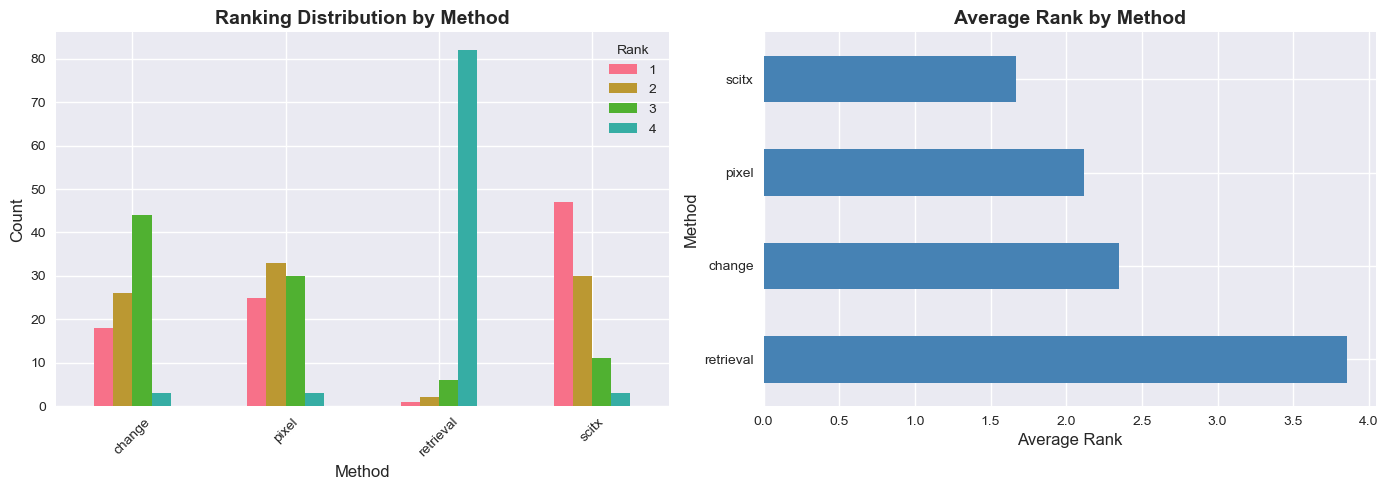

In [ ]:
# Analyze rankings
if connection_string != "your_connection_string_here" and len(data) > 0:
    # Extract rankings for each method
    methods = ['retrieval', 'pixel', 'change', 'scitx']
    
    ranking_data = []
    for _, row in df.iterrows():
        rankings = row.get('rankings', {})
        for method in methods:
            ranking_data.append({
                'participant_id': row['participant_id'],
                'sample_key': row['sample_key'],
                'method': method,
                'rank': rankings.get(method, None)
            })
    
    ranking_df = pd.DataFrame(ranking_data)
    ranking_df = ranking_df[ranking_df['rank'].notna()]  # Remove missing rankings
    
    print("📊 Ranking Distribution by Method:")
    print(ranking_df.groupby(['method', 'rank']).size().unstack(fill_value=0))
    
    # Calculate average rank for each method
    avg_ranks = ranking_df.groupby('method')['rank'].mean().sort_values()
    print("\n🏆 Average Rank (lower is better):")
    print(avg_ranks)
    
    # Visualize ranking distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Ranking distribution
    ranking_pivot = ranking_df.groupby(['method', 'rank']).size().unstack(fill_value=0)
    ranking_pivot.plot(kind='bar', ax=axes[0], stacked=False)
    axes[0].set_title('Ranking Distribution by Method', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Method', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].legend(title='Rank', title_fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Average rank
    avg_ranks.plot(kind='barh', ax=axes[1], color='steelblue')
    axes[1].set_title('Average Rank by Method', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Average Rank', fontsize=12)
    axes[1].set_ylabel('Method', fontsize=12)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No data available for analysis")


👥 Participant Statistics:
   participant_id  num_samples        first_submission         last_submission
0   Daeheon Jeong            4 2025-12-05 05:40:32.209 2025-12-05 05:52:58.267
1          Eunhye            4 2025-12-05 05:39:54.308 2025-12-05 05:44:27.624
2            Gosu            4 2025-12-05 05:38:17.773 2025-12-05 05:52:37.191
3          Hayeon            3 2025-12-05 05:45:24.600 2025-12-05 05:58:10.505
4         Heechan            4 2025-12-05 05:42:37.216 2025-12-05 05:58:09.777
5           Jenny            4 2025-12-05 05:42:34.110 2025-12-05 06:07:17.572
6        Jiho Kim            4 2025-12-05 05:39:23.199 2025-12-05 05:59:05.724
7         Minbeom            4 2025-12-05 05:39:22.528 2025-12-05 05:55:26.949
8         Saelyne            4 2025-12-05 05:39:08.715 2025-12-05 05:45:46.661
9          Sehoon            4 2025-12-05 05:38:17.357 2025-12-05 05:51:13.013
10        Seungju            3 2025-12-05 05:38:53.857 2025-12-05 05:57:01.751
11         Shujun         

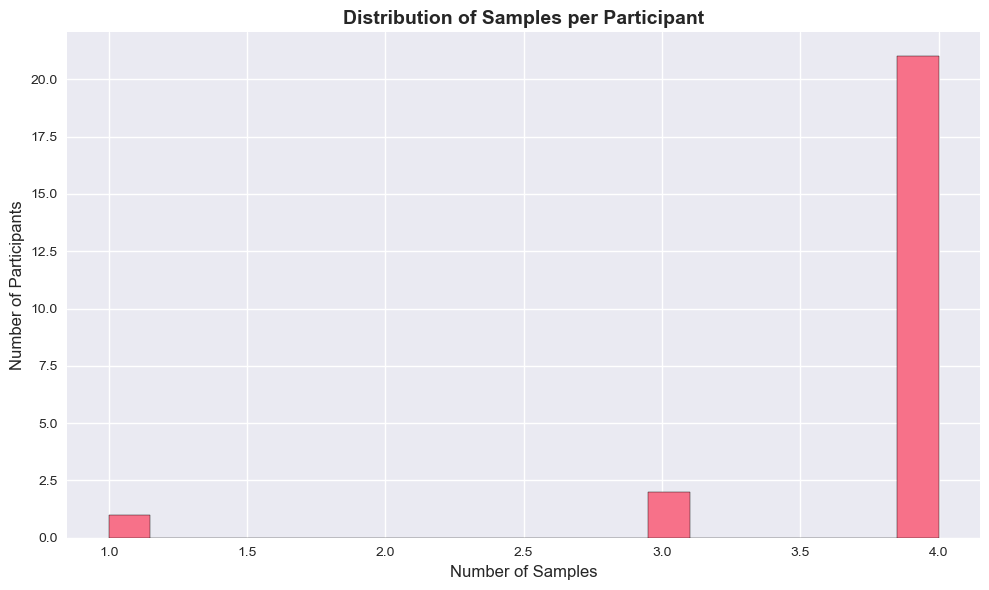


📊 Summary:
   Average samples per participant: 3.79
   Min samples: 1
   Max samples: 4


In [18]:
# Participant statistics
if connection_string != "your_connection_string_here" and len(data) > 0:
    participant_stats = df.groupby('participant_id').agg({
        'sample_key': 'count',
        'timestamp': ['min', 'max']
    }).reset_index()
    participant_stats.columns = ['participant_id', 'num_samples', 'first_submission', 'last_submission']
    
    print("👥 Participant Statistics:")
    print(participant_stats)
    
    # Visualize samples per participant
    fig, ax = plt.subplots(figsize=(10, 6))
    participant_stats['num_samples'].hist(bins=20, ax=ax, edgecolor='black')
    ax.set_title('Distribution of Samples per Participant', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Samples', fontsize=12)
    ax.set_ylabel('Number of Participants', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Summary:")
    print(f"   Average samples per participant: {participant_stats['num_samples'].mean():.2f}")
    print(f"   Min samples: {participant_stats['num_samples'].min()}")
    print(f"   Max samples: {participant_stats['num_samples'].max()}")
else:
    print("⚠️ No data available for analysis")


💬 Feedback Statistics:
   Total feedback entries: 308
   Average feedback length: 111.8 characters

📝 Feedback count by method:
method
change       72
pixel        74
retrieval    84
scitx        78
dtype: int64


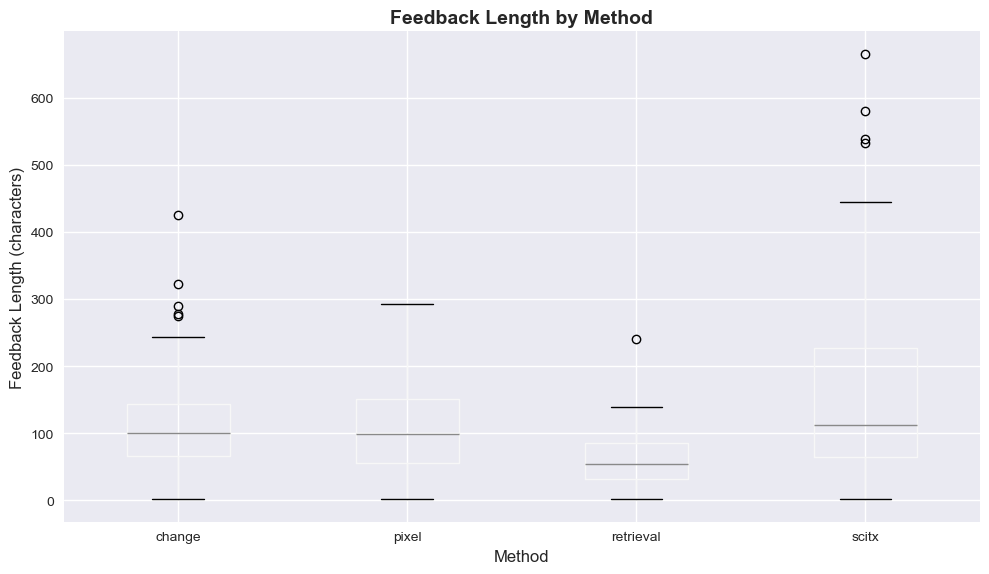

In [19]:
# Feedback analysis
if connection_string != "your_connection_string_here" and len(data) > 0:
    feedback_data = []
    for _, row in df.iterrows():
        feedbacks = row.get('ranking_feedback', {})
        for method in methods:
            feedback = feedbacks.get(method, '')
            if feedback and feedback.strip():  # Only non-empty feedback
                feedback_data.append({
                    'method': method,
                    'rank': row.get('rankings', {}).get(method, None),
                    'feedback_length': len(feedback),
                    'has_feedback': True
                })
    
    if feedback_data:
        feedback_df = pd.DataFrame(feedback_data)
        
        print("💬 Feedback Statistics:")
        print(f"   Total feedback entries: {len(feedback_df)}")
        print(f"   Average feedback length: {feedback_df['feedback_length'].mean():.1f} characters")
        print(f"\n📝 Feedback count by method:")
        print(feedback_df.groupby('method').size())
        
        # Feedback length by method
        fig, ax = plt.subplots(figsize=(10, 6))
        feedback_df.boxplot(column='feedback_length', by='method', ax=ax)
        ax.set_title('Feedback Length by Method', fontsize=14, fontweight='bold')
        ax.set_xlabel('Method', fontsize=12)
        ax.set_ylabel('Feedback Length (characters)', fontsize=12)
        plt.suptitle('')  # Remove default title
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No feedback data available")
else:
    print("⚠️ No data available for analysis")


📸 Sample Statistics:
   Total samples: 4
   Average responses per sample: 22.75

📊 Top 5 most evaluated samples:
  sample_key  num_responses
3       7291             24
0      11513             23
1      11533             23
2       4351             21


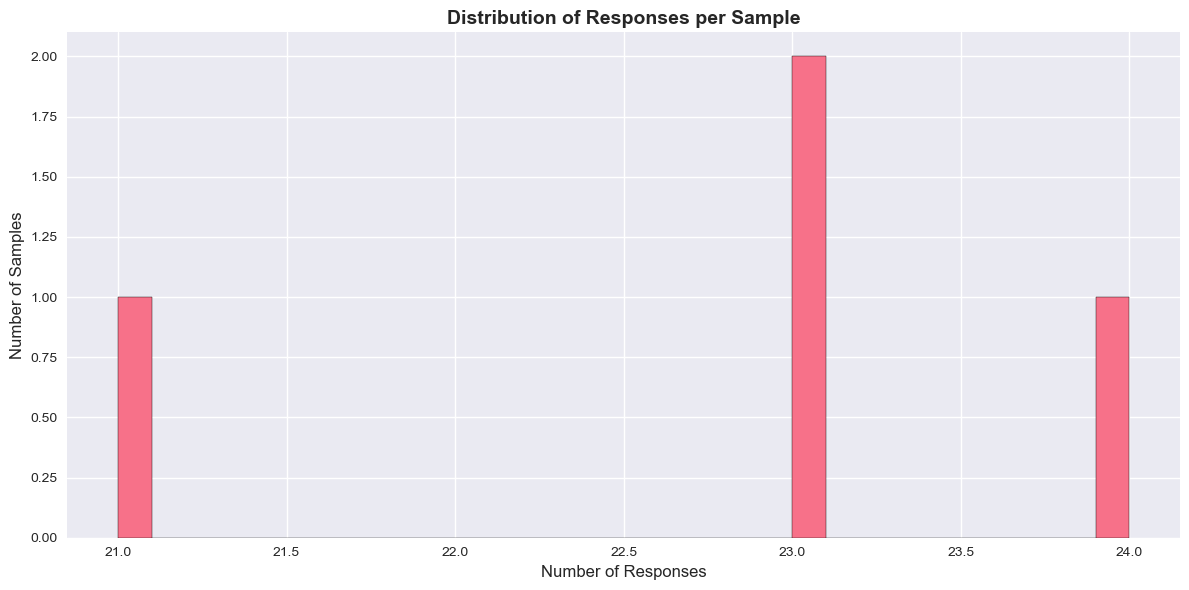

In [20]:
# Sample-level analysis
if connection_string != "your_connection_string_here" and len(data) > 0:
    sample_stats = df.groupby('sample_key').agg({
        'participant_id': 'count',
        'rankings': lambda x: list(x)  # Collect all rankings for this sample
    }).reset_index()
    sample_stats.columns = ['sample_key', 'num_responses', 'all_rankings']
    
    # Calculate average rank per sample for each method
    sample_ranking_data = []
    for _, row in df.iterrows():
        rankings = row.get('rankings', {})
        for method in methods:
            if method in rankings:
                sample_ranking_data.append({
                    'sample_key': row['sample_key'],
                    'method': method,
                    'rank': rankings[method]
                })
    
    sample_ranking_df = pd.DataFrame(sample_ranking_data)
    sample_avg_ranks = sample_ranking_df.groupby(['sample_key', 'method'])['rank'].mean().unstack()
    
    print("📸 Sample Statistics:")
    print(f"   Total samples: {len(sample_stats)}")
    print(f"   Average responses per sample: {sample_stats['num_responses'].mean():.2f}")
    print(f"\n📊 Top 5 most evaluated samples:")
    print(sample_stats.nlargest(5, 'num_responses')[['sample_key', 'num_responses']])
    
    # Visualize responses per sample
    fig, ax = plt.subplots(figsize=(12, 6))
    sample_stats['num_responses'].hist(bins=30, ax=ax, edgecolor='black')
    ax.set_title('Distribution of Responses per Sample', fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Responses', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No data available for analysis")


In [21]:
# Export data for further analysis
if connection_string != "your_connection_string_here" and len(data) > 0:
    # Export to CSV (flattened structure)
    export_data = []
    for _, row in df.iterrows():
        rankings = row.get('rankings', {})
        feedbacks = row.get('ranking_feedback', {})
        for method in methods:
            export_data.append({
                'participant_id': row['participant_id'],
                'sample_key': row['sample_key'],
                'timestamp': row.get('timestamp', ''),
                'true_class': row.get('true_class', ''),
                'predicted_class': row.get('predicted_class', ''),
                'method': method,
                'rank': rankings.get(method, None),
                'feedback': feedbacks.get(method, ''),
                'cei_score': row.get('cei_scores', {}).get(method, None),
                'explanation_order': row.get('explanation_order', {}).get(method, None)
            })
    
    export_df = pd.DataFrame(export_data)
    
    # Save to CSV
    output_file = 'human_study_data_export.csv'
    export_df.to_csv(output_file, index=False)
    print(f"✅ Data exported to {output_file}")
    print(f"   Total rows: {len(export_df)}")
    print(f"   Columns: {list(export_df.columns)}")
    
    # Display summary
    print("\n📊 Overall Summary:")
    print(f"   Total participants: {df['participant_id'].nunique()}")
    print(f"   Total samples: {df['sample_key'].nunique()}")
    print(f"   Total responses: {len(df)}")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    display(export_df.head(10))
else:
    print("⚠️ No data available for export")


✅ Data exported to human_study_data_export.csv
   Total rows: 364
   Columns: ['participant_id', 'sample_key', 'timestamp', 'true_class', 'predicted_class', 'method', 'rank', 'feedback', 'cei_score', 'explanation_order']

📊 Overall Summary:
   Total participants: 24
   Total samples: 4
   Total responses: 91
   Date range: 2025-12-05 05:36:30.282000 to 2025-12-05 07:15:42.515000


,participant_id,sample_key,timestamp,true_class,predicted_class,method,rank,feedback,cei_score,explanation_order
0,taesoo,7291,2025-12-05 05:36:30.282,whippet,italian_greyhound,retrieval,4,WHOLE: This doesn't really affect the classifi...,38.940298,3
1,taesoo,7291,2025-12-05 05:36:30.282,whippet,italian_greyhound,pixel,2,"""focusing too much on these commonalities whil...",31.810471,0
2,taesoo,7291,2025-12-05 05:36:30.282,whippet,italian_greyhound,change,3,"""due to the lack of these details in the first...",35.319280,2
3,taesoo,7291,2025-12-05 05:36:30.282,whippet,italian_greyhound,scitx,1,"""Set A shows a whippet with a long tail and sl...",41.590893,1
4,hyehyun,7291,2025-12-05 05:37:38.235,whippet,italian_greyhound,retrieval,3,Harsh shadows create false edges on the object...,38.940298,1
5,hyehyun,7291,2025-12-05 05:37:38.235,whippet,italian_greyhound,pixel,4,focusing too much on these commonalities : Thi...,31.810471,3
6,hyehyun,7291,2025-12-05 05:37:38.235,whippet,italian_greyhound,change,2,"elongated snout and pointed ears, which are ke...",35.319280,2
7,hyehyun,7291,2025-12-05 05:37:38.235,whippet,italian_greyhound,scitx,1,Greyhound due to the slender build and pointed...,41.590893,0
8,jaesang,7291,2025-12-05 05:38:17.252,whippet,italian_greyhound,retrieval,4,shadows: can't be a different trait of species.,38.940298,1
9,jaesang,7291,2025-12-05 05:38:17.252,whippet,italian_greyhound,pixel,2,The model may have been misled by the similari...,31.810471,2
